## Homework: Introduction

## Q1. Running Elastic 

Run Elastic Search 8.17.6, and get the cluster information. If you run it on localhost, this is how you do it:

```bash
curl localhost:9200
```

What's the `version.build_hash` value?

### Ans
- dbcbbbd0bc4924cfeb28929dc05d82d662c527b7
- 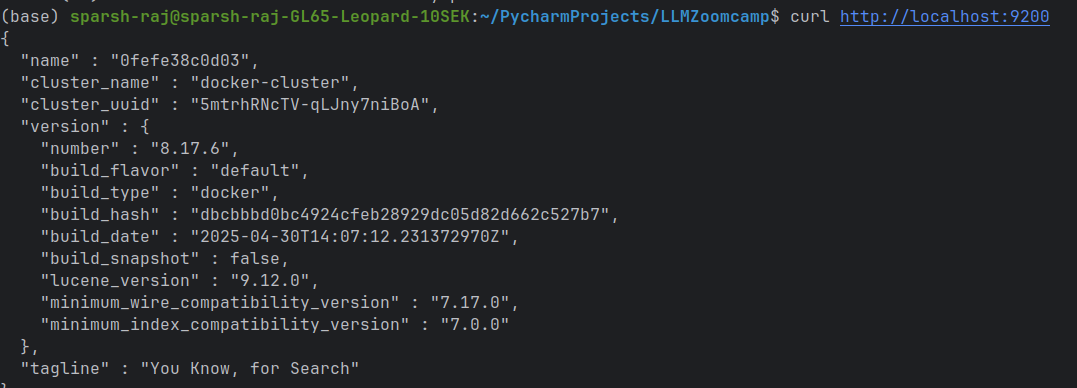

 docker run -it \
    --rm \
    --name elasticsearch \
    -m 4GB \
    -p 9200:9200 \
    -p 9300:9300 \
    -e "discovery.type=single-node" \
    -e "xpack.security.enabled=false" \
    docker.elastic.co/elasticsearch/elasticsearch:8.17.6


## Getting the data

In [2]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []-

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

In [9]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

## Q2. Indexing the data

Index the data in the same way as was shown in the course videos. Make the `course` field a keyword and the rest should be text. 

Don't forget to install the ElasticSearch client for Python:

```bash
pip install elasticsearch
```

Which function do you use for adding your data to elastic?

* `insert`
* `index`
* `put`
* `add`

### Ans
* `index`

In [2]:
pip install elasticsearch

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [6]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200')
es_client.info()

ObjectApiResponse({'name': 'cbbf30239743', 'cluster_name': 'docker-cluster', 'cluster_uuid': '31ZaP7BGTGiDqyJ-HvfryA', 'version': {'number': '9.0.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '0a58bc1dc7a4ae5412db66624aab968370bd44ce', 'build_date': '2025-05-28T10:06:37.834829258Z', 'build_snapshot': False, 'lucene_version': '10.1.0', 'minimum_wire_compatibility_version': '8.18.0', 'minimum_index_compatibility_version': '8.0.0'}, 'tagline': 'You Know, for Search'})

In [7]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"}
        }
    }
}

index_name = "course-questions"

es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [8]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

## Q3. Searching

Now let's search in our index. 

We will execute a query "How do execute a command on a Kubernetes pod?". 

Use only `question` and `text` fields and give `question` a boost of 4, and use `"type": "best_fields"`.

What's the score for the top ranking result?

* 84.50
* 64.50
* 44.50
* 24.50

Look at the `_score` field.

In [58]:
def elastic_search(query):
    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^4", "text"],
                        "type": "best_fields"
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)

    result_docs = []

    for hit in response['hits']['hits']:
        result_docs.append(hit)

    return result_docs

In [57]:
query = "How do execute a command on a Kubernetes pod?"

In [61]:
top_results = elastic_search(query)
top_results

[{'_index': 'course-questions',
  '_id': 'FYFvfJcB_d8vI1QnFUBW',
  '_score': 44.50556,
  '_source': {'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)',
   'section': '5. Deploying Machine Learning Models',
   'question': 'How do I debug a docker container?',
   'course': 'machine-learning-zoomcamp'}},
 {'_index': 'course-questions',
  '_id': 'pIFvfJcB_d8vI1QnG0B9',
  '_score': 35.433445,
  '_source': {'text': 'Deploy and Access the Kubernetes Dashboard\nLuke',
   'section': '10. Kubernetes and TensorFlow Serving',
   'question': 'Kubernetes-dashboard',
   'course': 'machine-learning-zoomcamp'}},
 {'_index': 'course-questions',
  '_id': 'NYFvfJcB_d8vI1QnFUDz',
  '_score': 33.70974,
  '_source': {'text': 'You 

In [62]:
max_score = max(r["_score"] for r in top_results)

In [63]:
 print("Top ranking result score is: ", max_score)

Top ranking result score is:  44.50556


## Q4. Filtering

Now ask a different question: "How do copy a file to a Docker container?".

This time we are only interested in questions from `machine-learning-zoomcamp`.

Return 3 results. What's the 3rd question returned by the search engine?

* How do I debug a docker container?
* How do I copy files from a different folder into docker container’s working directory?
* How do Lambda container images work?
* How can I annotate a graph?

In [68]:
def elastic_search2(query):
    search_query = {
        "size": 3,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^4", "text"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "machine-learning-zoomcamp"
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)

    result_docs = []

    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [66]:
query = "How do copy a file to a Docker container?"

In [70]:
result = elastic_search2(query)
result

[{'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)',
  'section': '5. Deploying Machine Learning Models',
  'question': 'How do I debug a docker container?',
  'course': 'machine-learning-zoomcamp'},
 {'text': "You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:\nTo copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:\ndocker cp /path/to/local/file_or_directory container_id:/path/in/container\nHrithik Kumar Advani",
  'section': '5. Deploying Machine Learning Models',
  'question': 'How do I copy files from my local machine to docker container?',
 

In [76]:
print("The 3rd question returned by the search engine is:\n",result[2]['question'])

The 3rd question returned by the search engine is:
 How do I copy files from a different folder into docker container’s working directory?


## Q5. Building a prompt

Now we're ready to build a prompt to send to an LLM. 

Take the records returned from Elasticsearch in Q4 and use this template to build the context. Separate context entries by two linebreaks (`\n\n`)
```python
context_template = """
Q: {question}
A: {text}
""".strip()
```

Now use the context you just created along with the "How do copy a file to a Docker container?" question 
to construct a prompt using the template below:

```
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()
```

What's the length of the resulting prompt? (use the `len` function)

* 946
* 1446
* 1946
* 2446

In [90]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

    context = ""

    for doc in search_results:
        context = context + f"Q: {doc['question']}\nA: {doc['text']}\n\n"
        
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [91]:
prompt = build_prompt(query, result)
prompt

'You\'re a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.\nUse only the facts from the CONTEXT when answering the QUESTION.\n\nQUESTION: How do copy a file to a Docker container?\n\nCONTEXT:\nQ: How do I debug a docker container?\nA: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)\n\nQ: How do I copy files from my local machine to docker container?\nA: You can copy files from your local machine into a Docker container using the docker cp command. Here\'s how to do it:\nTo copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:\ndocker cp /path/to/local/file_or_directory container

In [94]:
print("The length of the resulting prompt is:", len(prompt))

The length of the resulting prompt is: 1446


## Q6. Tokens

When we use the OpenAI Platform, we're charged by the number of 
tokens we send in our prompt and receive in the response.

The OpenAI python package uses `tiktoken` for tokenization:

```bash
pip install tiktoken
```

Let's calculate the number of tokens in our query: 

```python
encoding = tiktoken.encoding_for_model("gpt-4o")
```

Use the `encode` function. How many tokens does our prompt have?

* 120
* 220
* 320
* 420

Note: to decode back a token into a word, you can use the `decode_single_token_bytes` function:

```python
encoding.decode_single_token_bytes(63842)
```

In [95]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [97]:
import tiktoken

In [98]:
encoding = tiktoken.encoding_for_model("gpt-4o")

In [102]:
encoded_prompt = encoding.encode(prompt)

In [104]:
print("Our prompt have", len(encoded_prompt), "tokens")

Our prompt have 320 tokens


## Bonus: generating the answer (ungraded)

Let's send the prompt to OpenAI. What's the response?  

Note: you can replace OpenAI with Ollama. See module 2.

In [105]:
from openai import OpenAI
client = OpenAI()

In [106]:
def llm(prompt):
    response = client.chat.completions.create(
        model='gpt-4.1',
        messages=[{"role": "user", "content": prompt}]
    )

    return response.choices[0].message.content

In [109]:
def rag(query):
    search_results = elastic_search2(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [111]:
output = rag(query)
print(output)

You can copy a file from your local machine to a Docker container using the docker cp command. The basic syntax is:

docker cp /path/to/local/file_or_directory container_id:/path/in/container

Replace /path/to/local/file_or_directory with the path of your file, container_id with your container's ID or name, and /path/in/container with the destination path inside the container.


## Bonus: calculating the costs (ungraded)

Suppose that on average per request we send 150 tokens and receive back 250 tokens.

How much will it cost to run 1000 requests?

You can see the prices [here](https://openai.com/api/pricing/)

On June 17, the prices for gpt4o are:

* Input: $0.005 / 1K tokens
* Output: $0.02 / 1K tokens

You can redo the calculations with the values you got in Q6 and Q7.

### Answer
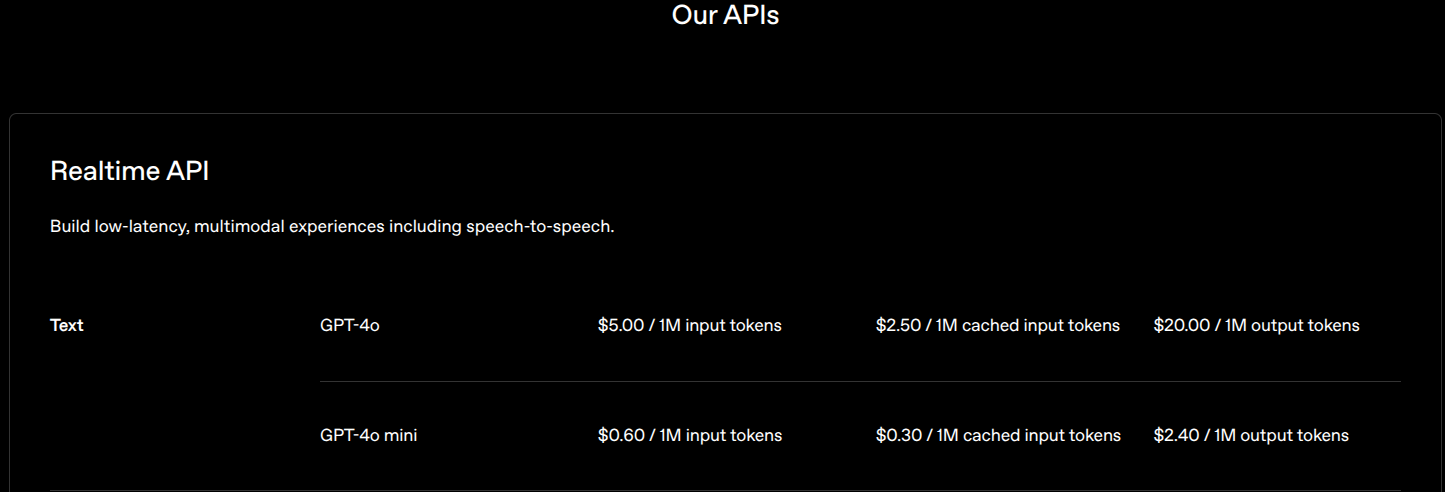

```
- Total number of input tokens in 1 request = 150
- Total number of input tokens in 1000 requests = 150 × 1000 = 150,000
- Cost of input tokens = $0.005 × 150,000 / 1000 = $0.75

- Total number of output tokens in 1 request = 250
- Total number of output tokens in 1000 requests = 250 × 1000 = 250,000
- Cost of output tokens = $0.02 × 250,000 / 1000 = $5.00

- Total cost of input and output = $0.75 + $5.00 = $5.75
```


In [112]:
encoded_output = encoding.encode(output)

In [113]:
print("Our output have", len(encoded_output), "tokens")

Our output have 78 tokens


```
- Total number of input tokens in 1 request = 320
- Total number of input tokens in 1000 requests = 320 * 1000 = 320,000
- Cost of input tokens = $0.005 * 320,000 / 1000 = $1.6

- Total number of output tokens in 1 request = 78
- Total number of output tokens in 1000 requests = 78 * 1000 = 78,000
- Cost of output tokens = $0.02 * 78,000 / 1000 = $1.56

- Total cost of input and output = $1.6 + $1.56 = $3.16
```